In [1]:
from netgen.meshing import *
from netgen.csg import *
from netgen.occ import *
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.webgui import Draw as DrawGeo
import math
import numpy as np
import sys
sys.path.append(r'..\..\bin\Release') 
from EMPY_Field import *
sys.path.append('..\model')
from Cylinder_Yaxis_1Layer import Cylinder_Yaxis_1Layer
sys.path.append('..\include')
from MatrixSolver import MatrixSolver as solver 
from HtoOmega import HtoOmega

model=Cylinder_Yaxis_1Layer()
mesh=model.mesh
symmetric_plane=model.symmetric_plane
Mu=model.Mu
reduced_region=model.reduced_region
total_region=model.total_region
total_boundary=model.total_boundary
reduced_boundary=model.reduced_boundary

Dirichlet=False
feorder=3
mu=4.e-7*math.pi

field=UNIF(0,1,0,0)
Ov=Ofield(field)
Bv=Bfield(field)
Hv=Bv/mu
Os=model.ReducedField(Ov, 0)
Bs=model.ReducedField(Bv, (0,0,0))

if Dirichlet==True:
    fesOmega=H1(mesh, order=feorder, dirichlet=reduced_boundary)
else:
    fesOmega=H1(mesh, order=feorder)
    
omega,psi = fesOmega.TnT() 
gfOmega = GridFunction(fesOmega)
a= BilinearForm(fesOmega)
a +=Mu*(grad(omega)*grad(psi))*dx
with TaskManager():
    a.Assemble()
normal = specialcf.normal(mesh.dim)

surfaceOmega=HtoOmega(mesh, total_boundary, feorder, Hv)
#surfaceOmega=y
# Calculate Dirichlet condition terms
#gfOmega.Set(Ov, BND, mesh.Boundaries(total_boundary))
gfOmega.Set(surfaceOmega, BND, mesh.Boundaries(total_boundary))

f = LinearForm(fesOmega)
f +=Mu*grad(gfOmega)*grad(psi)*dx(reduced_region)
with TaskManager():
    f.Assemble() 
#remove components of the Dirichlet boundary
fcut = np.array(f.vec.FV())[fesOmega.FreeDofs()]
np.array(f.vec.FV(), copy=False)[fesOmega.FreeDofs()] = fcut

# Add Neumann condition terms
f += (normal*Bv)*psi*ds(total_boundary)
with TaskManager():
    f.Assemble()
gfOmega = GridFunction(fesOmega)   #Clear gfOmega
gfOmega=solver.iccg_solve(fesOmega, gfOmega, a, f.vec.FV(), tol=1.e-16, max_iter=200, accel_factor=0, complex=False) 

fesOt=H1(mesh, order=feorder, definedon=total_region)
fesOr=H1(mesh, order=feorder, definedon=reduced_region)
Ot=GridFunction(fesOt)
Orr=GridFunction(fesOr)
Oxr=GridFunction(fesOr)

Ot.Set(gfOmega,VOL, definedon=total_region)
Orr.Set(gfOmega,VOL, definedon=reduced_region)
Oxr.Set(surfaceOmega, BND, mesh.Boundaries(total_boundary))
"""
for n in range(31):
    y=0.01*n
    mip = mesh(0,y,0)
    print("y= ", y, "  gfOmega= ",gfOmega(mip), " surfaceOmega= ", surfaceOmega(mip), "  Ot= ",
          Ot(mip), " Orr= ", Orr(mip), "  Oxr= ", Oxr(mip) )
"""
Bt=grad(Ot)*Mu
Or=Orr-Oxr
Br=(grad(Orr)-grad(Oxr))*mu

Draw ((Ot+Or+Os)*mu, mesh, order=3, min=0., max=1.0, deformation=False)       
Bfield=Bt+Br+Bs
Draw (Bfield, mesh, order=3, min=0.5, max=1.5, deformation=False)

mip = mesh(0,0,0)
print("center magnetic field = ", Bfield(mip))




enter iccg_solve
Dof= 372    matrix size= 3138.0
shift parameter= 1.0
minimum residual= 3.3327678710480884e-15  at iteraions:  28
結果のノルム: 1.1234789633486865e-08
power=  39788796660.769035
enter iccg_solve
Dof= 13024    matrix size= 418893.0
shift parameter= 1.0
minimum residual= 9.80491865745545e-17  at iteraions:  75
結果のノルム: 1.2086209921715752e-15
power=  62882.30134959729
y=  0.0   gfOmega=  632.2489929247263  surfaceOmega=  0.0   Ot=  632.2489929247422  Orr=  0.0   Oxr=  0.0
y=  0.01   gfOmega=  2067.3727376863494  surfaceOmega=  0.0   Ot=  2067.372737686347  Orr=  0.0   Oxr=  0.0
y=  0.02   gfOmega=  3502.4964460049746  surfaceOmega=  0.0   Ot=  3502.4964460049946  Orr=  0.0   Oxr=  0.0
y=  0.03   gfOmega=  4937.620106387845  surfaceOmega=  0.0   Ot=  4937.62010638785  Orr=  0.0   Oxr=  0.0
y=  0.04   gfOmega=  6372.743704369221  surfaceOmega=  0.0   Ot=  6372.743704369208  Orr=  0.0   Oxr=  0.0
y=  0.05   gfOmega=  7807.867238914376  surfaceOmega=  0.0   Ot=  7807.86723891436  Orr

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

center magnetic field =  (5.667939415855817e-08, 1.8034297051795165, 2.842349898372076e-12)


In [2]:
help(Orr)

Help on GridFunction in module ngsolve.comp object:

class GridFunction(ngsolve.fem.CoefficientFunction)
 |  a field approximated in some finite element space
 |   Keyword arguments can be:
 |  multidim: 
 |   Multidimensional GridFunction
 |  nested: bool = False
 |   Generates prolongation matrices for each mesh level and prolongates
 |   the solution onto the finer grid after a refinement.
 |  autoupdate: 
 |   Automatically update on FE space update
 |  
 |  Method resolution order:
 |      GridFunction
 |      ngsolve.fem.CoefficientFunction
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  AddMultiDimComponent(...)
 |      AddMultiDimComponent(self: ngsolve.comp.GridFunction, arg0: ngsolve.la.BaseVector) -> None
 |  
 |  CF(...)
 |      CF(self: ngsolve.comp.GridFunction, diffop: ngsolve.fem.DifferentialOperator) -> ngsolve.fem.CoefficientFunction
 |      
 |      
 |      
 |      Parameters:
 |      
 |      diffop : ngsol

Dirichlet=False

center magnetic field =  (5.667939415855817e-08, 1.8034297051795165, 2.842349898372076e-12)

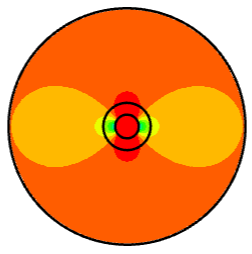

Dirichlet=True

center magnetic field =  (5.857076949050397e-08, 1.8331838248112047, 2.839408043562641e-12)

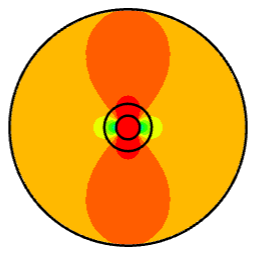